In [1]:
import numpy as np
import networkx as nx
import functools as ft
import math
import random
from datasets import load_dataset

/home/p4ssenger/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MUTAG = load_dataset("graphs-datasets/MUTAG")
PROTEINS = load_dataset("graphs-datasets/PROTEINS")
AIDS = load_dataset("graphs-datasets/AIDS")

In [3]:
def hdv(d):
    return np.random.choice([-1, 1], d)


def bind(xs):
    return ft.reduce(lambda x, y: x * y, xs)


def bundle(xs):
    return np.sign(ft.reduce(lambda x, y: x + y, xs))


def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)

    return dot_product / (norm_A * norm_B)


class ItemMemory:
    def __init__(self, vectors=[]):
        self.vectors = vectors

    def addVector(self, label, V):
        self.vectors.append((label, V))

    def count(self):
        return len(self.vectors)

    def cleanup(self, V):
        return max(self.vectors, key=lambda x: cosine_similarity(V, x[1]))

In [4]:
def encodeGraph(graph, vertices, dimensions):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)

    Edges = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        E = bind([v1, v2])
        Edges.append(E)

    Graph = bundle(Edges)

    return Graph

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin


class GraphHD(BaseEstimator, ClassifierMixin):
    def __init__(self, dimensions=10000, step=20):
        self.dimensions = dimensions
        self.step = step
        self.vertices = dict()

    def fit(self, X, y):
        self.memory = ItemMemory([])
        self.labels = list(set(y))
        dictLabels = dict()

        for label in self.labels:
            dictLabels[label] = []

        for i in range(len(X)):
            Graph = encodeGraph(X[i], self.vertices, self.dimensions)
            dictLabels[y[i]].append(Graph)

        for key, value in dictLabels.items():
            for i in range(0, len(value), self.step):
                H = bundle(value[i : i + self.step])
                self.memory.addVector(str(key), H)

        return self

    def predict(self, X):
        predictions = []
        similarities = []
        for testGraph in X:
            queryVector = encodeGraph(testGraph, self.vertices, self.dimensions)
            cleanVector = self.memory.cleanup(queryVector)

            predictions.append(int(cleanVector[0]))
            similarities.append(cosine_similarity(queryVector, cleanVector[1]))

        # print(
        #     "%.5f" % round(np.mean(similarities), 5),
        #     "0:",
        #     predictions.count(0),
        #     "1:",
        #     predictions.count(1),
        # )
        return predictions

In [6]:
def processDataset(dataset):
    graphs = []
    labels = []

    for graph in dataset:
        G = nx.Graph()
        G.add_edges_from(zip(graph["edge_index"][0], graph["edge_index"][1]))
        graphs.append(G)
        labels.append(graph["y"][0])

    return {"graphs": graphs, "y": labels}


def transformDataset(dataset, digits, alpha):
    graphs = []

    for graph in dataset:
        gpr = nx.pagerank(graph, alpha)
        nodes = dict()
        for key, value in gpr.items():
            nodes[key] = str(round(value, digits))
        H = nx.relabel_nodes(graph, nodes)
        graphs.append(H)

    return graphs

In [7]:
import pandas as pd
from numpy.random import randint
from sklearn.base import BaseEstimator, TransformerMixin


class GraphHDTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, digits=5, alpha=0.55):
        self.digits = digits
        self.alpha = alpha

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return transformDataset(X, self.digits, self.alpha)

In [8]:
# import pandas as pd
# from sklearn.pipeline import Pipeline


# df = MUTAG["train"]
# dataset = processDataset(df)

# pipe = Pipeline([("transformer", GraphHDTransformer()), ("classifier", GraphHD())])

# distributions = dict(
#     transformer__alpha=[0.25, 0.35, 0.45],
#     transformer__digits=[2, 3, 4, 5, 6],
#     classifier__dimensions=[2500, 10000],
#     classifier__step=[1, 2, 4, 8, 32, 64, 124, 256],
# )
# clf = GridSearchCV(pipe, distributions, n_jobs=-1, verbose=3)
# search = clf.fit(dataset["graphs"], dataset["y"])
# print("Search P =>", search.best_params_)
# print("Search S => %.5f" % search.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END classifier__dimensions=10000, classifier__step=1, transformer__alpha=0.25, transformer__digits=2;, score=0.632 total time=   0.6s
[CV 2/5] END classifier__dimensions=10000, classifier__step=1, transformer__alpha=0.25, transformer__digits=2;, score=0.711 total time=   0.7s
[CV 3/5] END classifier__dimensions=10000, classifier__step=1, transformer__alpha=0.25, transformer__digits=2;, score=0.579 total time=   0.7s
[CV 5/5] END classifier__dimensions=10000, classifier__step=1, transformer__alpha=0.25, transformer__digits=3;, score=0.784 total time=   0.7s
[CV 5/5] END classifier__dimensions=10000, classifier__step=1, transformer__alpha=0.25, transformer__digits=2;, score=0.541 total time=   0.7s
[CV 1/5] END classifier__dimensions=10000, classifier__step=1, transformer__alpha=0.25, transformer__digits=3;, score=0.868 total time=   0.7s
[CV 2/5] END classifier__dimensions=10000, classifier__step=1, transformer__al

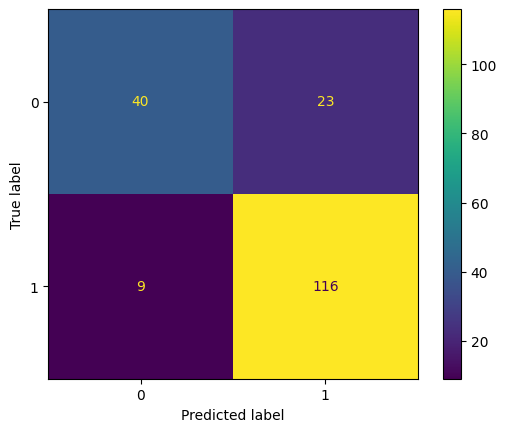

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# DATASET = MUTAG["train"]
DATASET = PROTEINS["train"]
# DATASET = AIDS["full"]
DIMENSIONS = 10000
DIGITS = 5
ALPHA = 0.25
STEP = 2

dataset = processDataset(DATASET)


def reps(clf, graphs, labels, reps):
    sum = 0
    for i in range(reps):
        scores = cross_val_score(clf, graphs, labels, cv=10, n_jobs=-1)
        sum += scores.mean()
        print(i + 1, "->", "%.5f" % scores.mean())

    print("r10f10 S => %.5f" % (sum / reps))


def hpSearch(graphs, labels):
    pipe = Pipeline([("transformer", GraphHDTransformer()), ("classifier", GraphHD())])

    distributions = dict(
        transformer__alpha=[0.25, 0.35, 0.45, 0.55, 0.65, 0.75],
        transformer__digits=[2, 3, 4, 5, 6],
        classifier__dimensions=[10000],
        classifier__step=[1, 2, 4, 8, 32, 64, 124, 256],
    )
    clf = GridSearchCV(pipe, distributions, n_jobs=-1, verbose=3)
    search = clf.fit(dataset["graphs"], dataset["y"])
    print("Search P =>", search.best_params_)
    print("Search S => %.5f" % search.best_score_)
    return search.best_estimator_


def confusionMatrix(clf, graphs, labels):
    y_pred = cross_val_predict(clf, graphs, labels, n_jobs=-1)
    conf_mat = confusion_matrix(labels, y_pred)
    accuracy = accuracy_score(y_pred, labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1])
    disp.plot()
    print(conf_mat)
    plt.show()


def main():
    pipe = hpSearch(dataset["graphs"], dataset["y"])
    # pipe = Pipeline(
    #     [
    #         ("transformer", GraphHDTransformer(DIGITS, ALPHA)),
    #         ("classifier", GraphHD(DIMENSIONS, STEP)),
    #     ]
    # )
    print(pipe.get_params())
    reps(pipe, dataset["graphs"], dataset["y"], 9)
    confusionMatrix(pipe, dataset["graphs"], dataset["y"])


main()

# reps(GraphHD(DIMENSIONS, DIGITS, ALPHA, STEP), 3)
# gridSearch()
# confusionMatrix(GraphHD(DIMENSIONS, DIGITS, ALPHA, STEP))

improvements in aids with multiple hvs per class -> /20
final score: 0.65210

improvements in proteins with multiple hvs per class -> /10
final score: 0.65496
[[550 113]
 [268 182]]

Mutag
{'alpha': 0.45, 'digits': 3, 'dimensions': 10000, 'step': 1}
0.7284495021337127

## AIDS

{'alpha': 0.55, 'digits': 6, 'dimensions': 10000, 'step': 20}
0.708
final score: 0.70400


# PROTEINS Dataset

GridSearch result

```python
dimensions=[1000, 2500, 10000],
digits=[2, 3, 4, 5, 6],
alpha=[0.25, 0.35, 0.45, 0.55, 0.75],
```

```json
{'alpha': 0.25, 'digits': 2, 'dimensions': 1000}
0.5956853714701248
```

3 repetition 10 fold validation and confusion matrix

```python
0.59568
[[663   0]
 [450   0]]
```

# AIDS Dataset

### Best result 10 reps

```python
{'alpha': 0.55, 'digits': 6, 'dimensions': 10000, 'step': 20}
S => 0.70006
[[  83  317]
 [ 293 1307]]
```

---

GridSearch result

```python
dimensions=[1000, 2500, 10000],
digits=[3, 4, 5, 6],
alpha=[0.25, 0.35, 0.45, 0.55, 0.75],
```

```json
{'alpha': 0.55, 'digits': 6, 'dimensions': 10000}
0.6055
```

3 repetition 10 fold validation and confusion matrix

```python
0.59467
[[ 159  241]
 [ 568 1032]]
```

```
# {'alpha': 0.45, 'digits': 4, 'dimensions': 10000} 10_iter_score: 0.65167 [[17 46] [29 96]]
# {'alpha': 0.75, 'digits': 3, 'dimensions': 5000}
# {'alpha': 0.45, 'digits': 4, 'dimensions': 1000} 0.65079
# {'alpha': 0.25, 'digits': 4, 'dimensions': 1000}
# {'alpha': 0.35, 'digits': 4, 'dimensions': 1000}
# 0.7073099415204679

# {'alpha': 0.35, 'digits': 3, 'dimensions': 1000}
# 0.7131578947368421
# 10 iter 0.68120

# {'alpha': 0.45, 'digits': 3, 'dimensions': 2500}
# 0.7330409356725146
# 10_iter_score: 0.69327 [[11  52] [ 9 116]]
```
